In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/_7/2hjw6wqd61180yf018mv4jdd8w_27h/T/ipykernel_16994/555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data overview

In [2]:
data_raw = pd.read_csv('2023_technical_challenge_data_analyst (1).csv')

In [17]:
no_activity_users = data[(data['POSTS_CREATED'] == 0) & (data['REPLIES_RECEIVED'] == 0) &
                         (data['THANKYOUS_RECEIVED'] == 0) & (data['EVENTS_CREATED'] == 0) &
                         (data['EVENT_PARTICIPANTS'] == 0) & (data['ITEMS_GIFTED'] == 0) &
                         (data['PLACES_RECOMMENDED'] == 0)]

no_activity_users

,USER_ID,LAST_X_WEEKS,POSTS_CREATED,REPLIES_RECEIVED,THANKYOUS_RECEIVED,EVENTS_CREATED,EVENT_PARTICIPANTS,ITEMS_GIFTED,PLACES_RECOMMENDED,Badge_Set
4,2,4,0,0,0,0,0,0,0,None
5,2,6,0,0,0,0,0,0,0,None
6,2,8,0,0,0,0,0,0,0,None
8,3,4,0,0,0,0,0,0,0,None
9,3,6,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...
79993,19999,6,0,0,0,0,0,0,0,None
79994,19999,8,0,0,0,0,0,0,0,None
79996,20000,4,0,0,0,0,0,0,0,None
79997,20000,6,0,0,0,0,0,0,0,None


### Fill the dataset with zeros instead of Nulls 

Plus save it to a new file to analyze in Tableau

In [3]:
data_raw_filled = data_raw.fillna(0).astype(int)

new_file_path = '2023_technical_challenge_data_analyst_without_Nulls.csv'
data_raw_filled.to_csv(new_file_path, index=False)
print(f"Dataset with Null values filled with zeros has been saved to {new_file_path}")

Dataset with Null values filled with zeros has been saved to 2023_technical_challenge_data_analyst_without_Nulls.csv


### Checking Metrics for Monotonicity

We want to ensure that for each user, the value of each metric does not decrease as LAST_X_WEEKS increases

In [4]:
metrics_columns = ['POSTS_CREATED', 'REPLIES_RECEIVED', 'THANKYOUS_RECEIVED', 
                   'EVENTS_CREATED', 'EVENT_PARTICIPANTS', 'ITEMS_GIFTED', 'PLACES_RECOMMENDED']

user_ids = data_raw_filled['USER_ID'].unique()

check_results = {metric: True for metric in metrics_columns}

for user_id in user_ids:
    user_data = data_raw_filled[data_raw_filled['USER_ID'] == user_id].sort_values(by='LAST_X_WEEKS')
    for metric in metrics_columns:
        if not user_data[metric].is_monotonic_increasing:
            check_results[metric] = False
            break

check_results

{'POSTS_CREATED': True,
 'REPLIES_RECEIVED': True,
 'THANKYOUS_RECEIVED': True,
 'EVENTS_CREATED': True,
 'EVENT_PARTICIPANTS': True,
 'ITEMS_GIFTED': True,
 'PLACES_RECOMMENDED': True}

### Outliers

You can find the same interactive plots on [the Tableau Dashboard](https://public.tableau.com/app/profile/margarita.akseshina/viz/NebenanTask/Dashboard1).

In [5]:
metrics = ['POSTS_CREATED', 'REPLIES_RECEIVED', 'THANKYOUS_RECEIVED', 
           'EVENTS_CREATED', 'EVENT_PARTICIPANTS', 'ITEMS_GIFTED', 'PLACES_RECOMMENDED']

def draw_metrics_boxplots(data):
    plt.figure(figsize=(20, 20))
    for i, metric in enumerate(metrics, 1):
        if i >= 4:
            i += 1
        plt.subplot(len(metrics)//4 + len(metrics)%4, 4, i)  # Adjusting the grid size based on the number of metrics
        ax = sns.boxplot(x='LAST_X_WEEKS', y=metric, data=data)
        ax.set_ylabel('')  
        plt.title(metric)
        plt.tight_layout()
    
    plt.show()

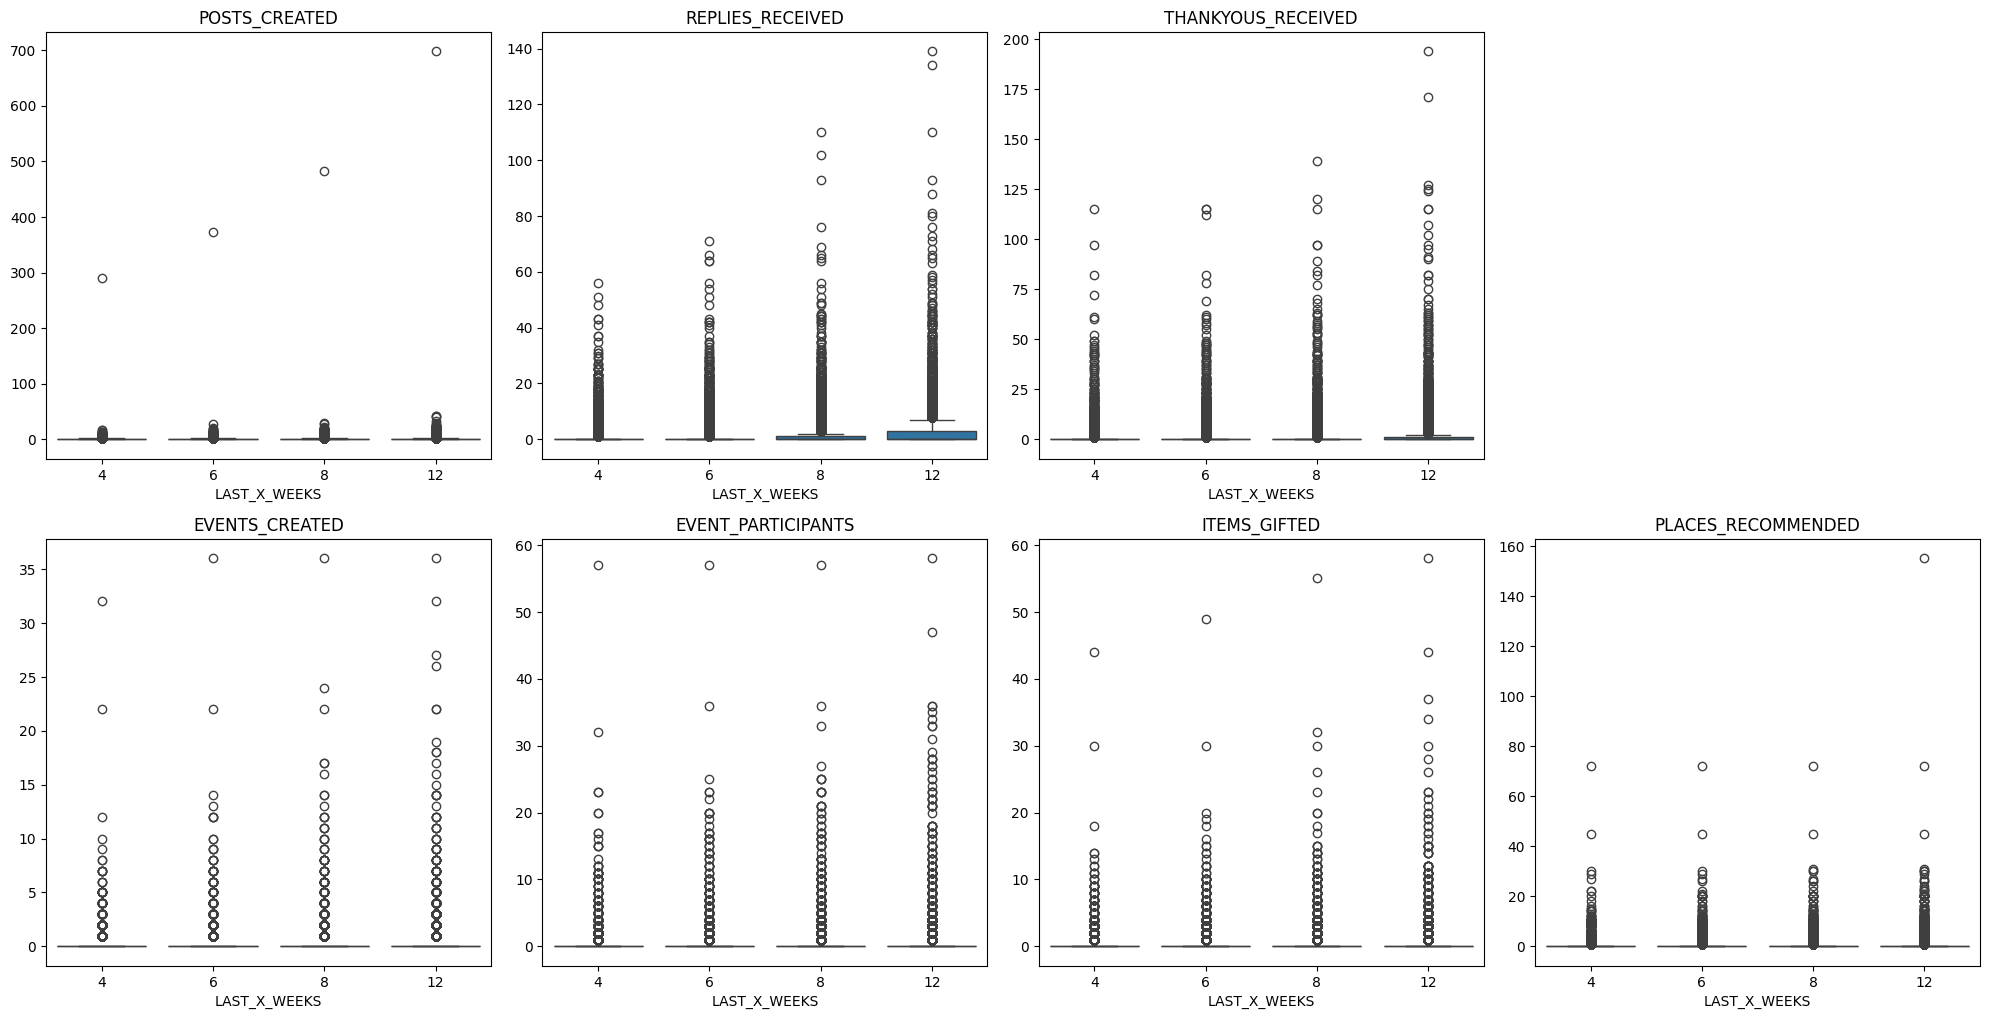

In [6]:
draw_metrics_boxplots(data_raw_filled)

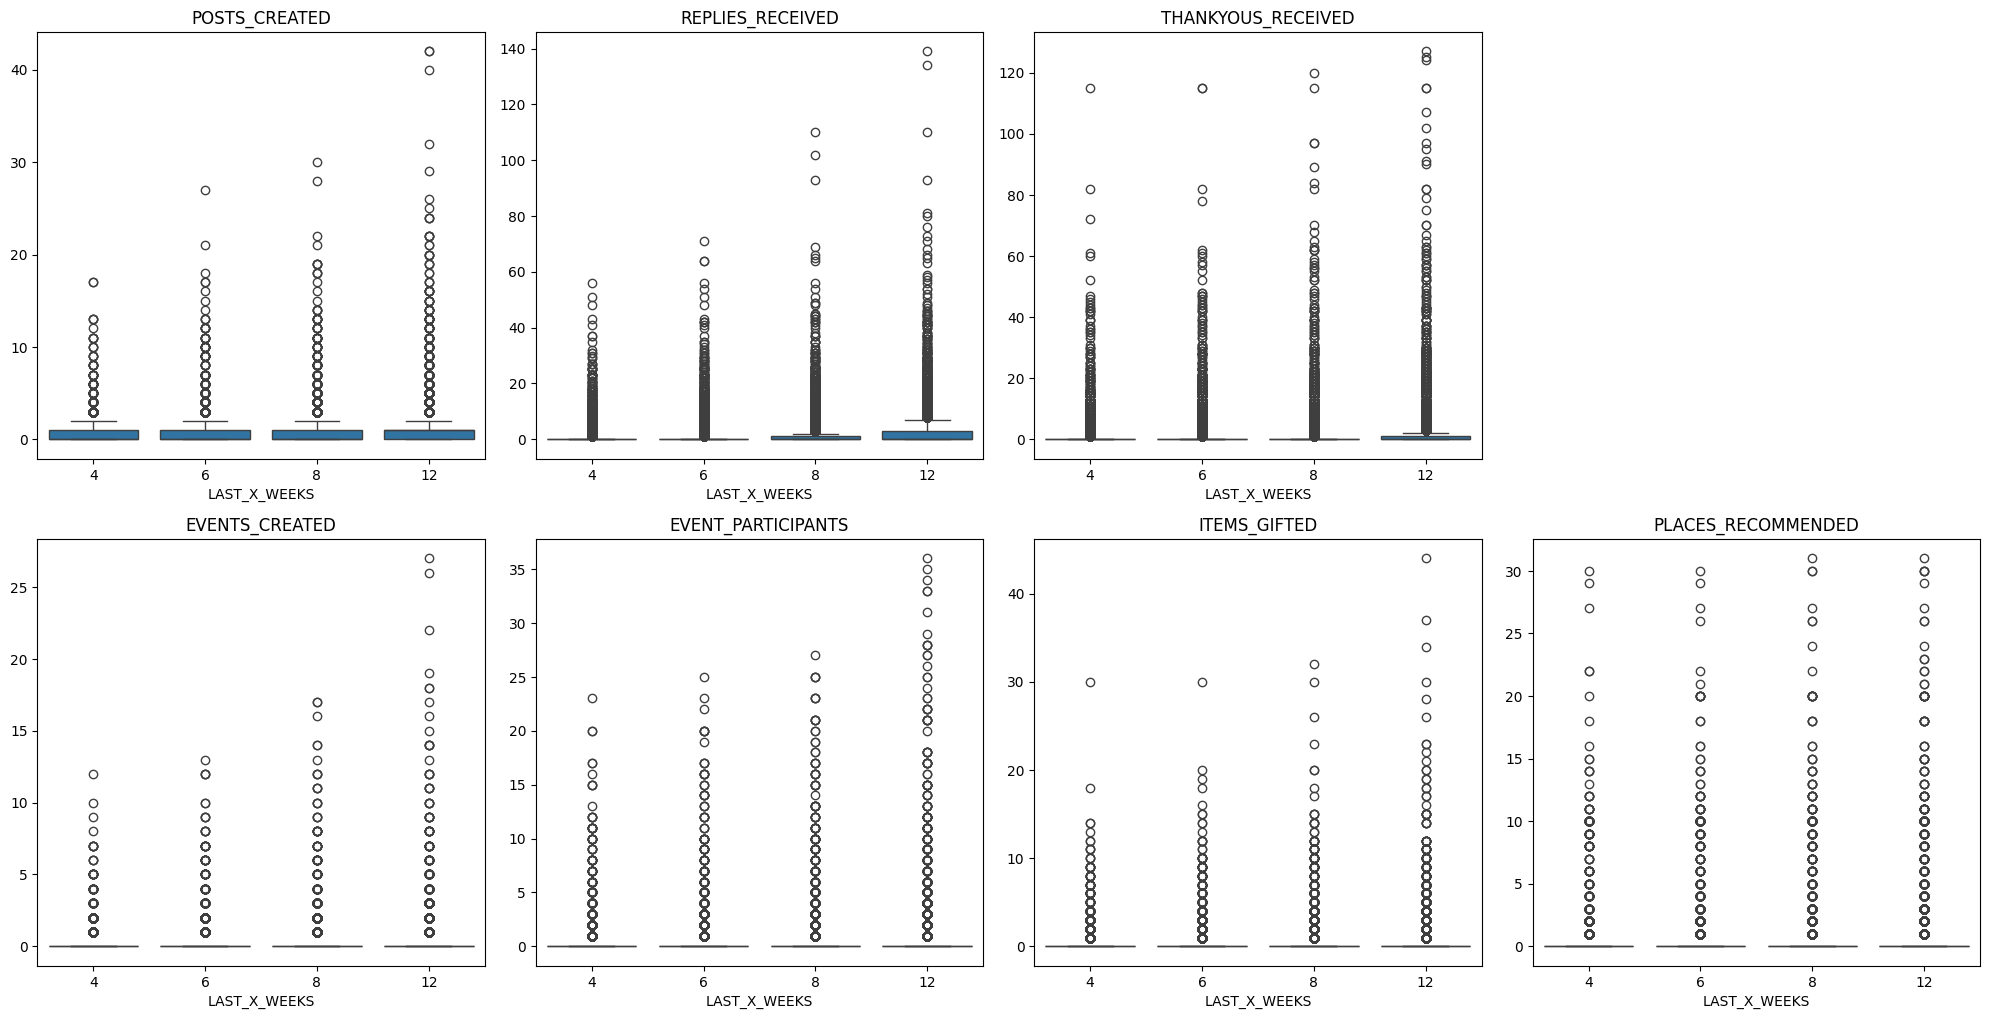

In [7]:
user_ids_to_filter = [17211, 9667, 14213, 3992, 629, 19366, 15751, 143, 19077, 17682]

data = data_raw_filled[~data_raw_filled['USER_ID'].isin(user_ids_to_filter)]

draw_metrics_boxplots(data)

#### Metrics statistics for a 12 weeks timeframe

In [8]:
data[data['LAST_X_WEEKS'] == 12].drop(columns=['USER_ID', 'LAST_X_WEEKS']).describe().loc[['count', 'min', '25%', '50%', '75%', 'max']].astype(int)

,POSTS_CREATED,REPLIES_RECEIVED,THANKYOUS_RECEIVED,EVENTS_CREATED,EVENT_PARTICIPANTS,ITEMS_GIFTED,PLACES_RECOMMENDED
count,19990,19990,19990,19990,19990,19990,19990
min,0,0,0,0,0,0,0
25%,0,0,0,0,0,0,0
50%,1,0,0,0,0,0,0
75%,1,3,1,0,0,0,0
max,42,139,127,27,36,44,31


# Choosing parameters for the criteria

In [9]:
badges = {
    'Philanthropist': ('ITEMS_GIFTED', None),
    'Helping Hand': ('THANKYOUS_RECEIVED', None),
    'Local Guide': ('PLACES_RECOMMENDED', None),
    'Event Planner': ('EVENTS_CREATED', 'EVENT_PARTICIPANTS'),
    'Conversation Starter': ('POSTS_CREATED', 'REPLIES_RECEIVED')
}

X_values = range(1, 8)  
Y_values = range(1, 8)  
Z_values = [4, 6, 8, 12]  

global_min = 0
global_max = -1

for badge_name, (column_X, column_Y) in badges.items():
    if column_Y: 
        for X in X_values:
            for Y in Y_values:
                for Z in Z_values:
                    eligible_users = data[(data[column_X] >= X) & (data[column_Y] >= Y) & (data['LAST_X_WEEKS'] == Z)]
                    percentage = (len(eligible_users) / len(data[data['LAST_X_WEEKS'] == Z])) * 100
                    global_max = max(global_max, percentage)
    else:  
        for X in X_values:
            for Z in Z_values:
                eligible_users = data[(data[column_X] >= X) & (data['LAST_X_WEEKS'] == Z)]
                percentage = (len(eligible_users) / len(data[data['LAST_X_WEEKS'] == Z])) * 100
                global_max = max(global_max, percentage)

print(global_min, global_max)

0 44.097048524262135


### Badges with 2 Parameters

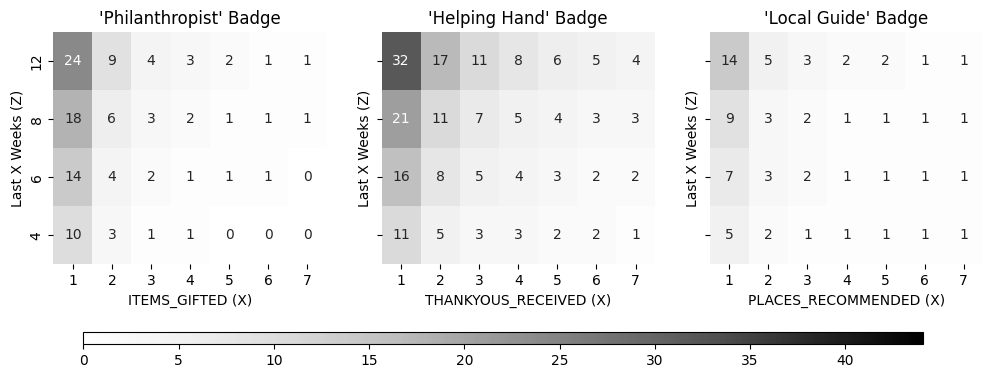

In [10]:
badges = {
    'Philanthropist': 'ITEMS_GIFTED',
    'Helping Hand': 'THANKYOUS_RECEIVED',
    'Local Guide': 'PLACES_RECOMMENDED'
}

fig, axes = plt.subplots(1, len(badges), figsize=(len(badges) * 4, 4), sharey='row')

for index, (badge_name, column_name) in enumerate(badges.items()):
    results = np.zeros((len(Z_values), len(X_values)))
    
    for i, Z in enumerate(Z_values):
        for j, X in enumerate(X_values):
            eligible_users = data[(data[column_name] >= X) & (data['LAST_X_WEEKS'] == Z)]
            percentage = (len(eligible_users) / len(data[data['LAST_X_WEEKS'] == Z])) * 100
            results[i, j] = percentage

    results_flipped_rounded = np.rint(np.flipud(results))
    
    ax = axes[index] if len(badges) > 1 else axes
    sns.heatmap(results_flipped_rounded, annot=True, xticklabels=X_values, yticklabels=list(reversed(Z_values)), 
                cmap="Greys", vmin=global_min, vmax=global_max, ax=ax, cbar=False)
    ax.set_title(f"'{badge_name}' Badge")
    ax.set_ylabel("Last X Weeks (Z)")
    ax.set_xlabel(f"{column_name} (X)")

fig.subplots_adjust(bottom=0.3)  
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  
sm = plt.cm.ScalarMappable(cmap="Greys", norm=plt.Normalize(vmin=global_min, vmax=global_max))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

plt.show()

### Badges with 3 Parameters

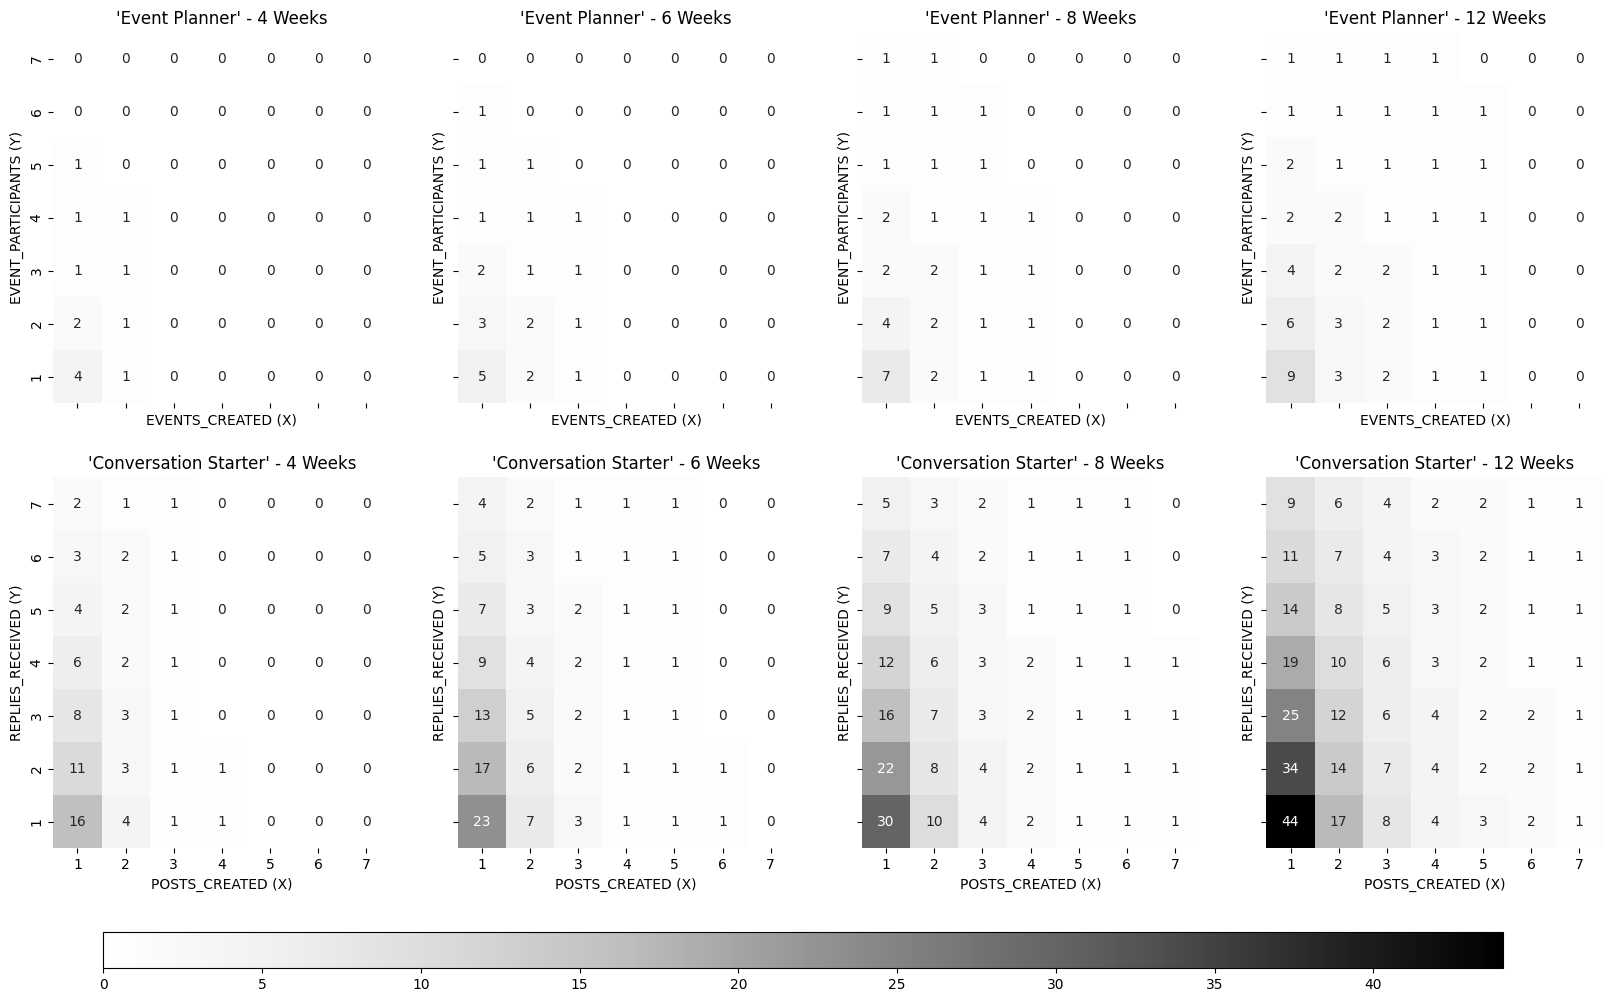

In [11]:
badges = {
    'Event Planner': ['EVENTS_CREATED', 'EVENT_PARTICIPANTS'],
    'Conversation Starter': ['POSTS_CREATED', 'REPLIES_RECEIVED']
}

fig, axs = plt.subplots(nrows=len(badges), ncols=len(Z_values), figsize=(5 * len(Z_values), 6 * len(badges)), sharex='col', sharey='row')

# Построение хитмапов
for badge_index, (badge_name, columns) in enumerate(badges.items()):
    for z_index, Z in enumerate(Z_values):
        results = np.zeros((len(X_values), len(Y_values)))

        for i, Y in enumerate(Y_values):
            for j, X in enumerate(X_values):
                eligible_users = data[(data[columns[0]] >= X) & (data[columns[1]] >= Y) & (data['LAST_X_WEEKS'] == Z)]
                percentage = (len(eligible_users) / len(data[data['LAST_X_WEEKS'] == Z])) * 100
                results[i, j] = percentage

        results_flipped_rounded = np.rint(np.flipud(results))

        ax = axs[badge_index, z_index]
        sns.heatmap(results_flipped_rounded, annot=True, xticklabels=Y_values, yticklabels=list(reversed(X_values)),
                    cmap="Greys", ax=ax, vmin=global_min, vmax=global_max, cbar=False)
        ax.set_title(f"'{badge_name}' - {Z} Weeks")
        ax.set_ylabel(f"{columns[1]} (Y)")
        ax.set_xlabel(f"{columns[0]} (X)")

fig.subplots_adjust(bottom=0.2) 
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03]) 
sm = plt.cm.ScalarMappable(cmap="Greys", norm=plt.Normalize(vmin=global_min, vmax=global_max))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

plt.show()

# Conclusions

In [20]:
data.loc[:, 'Badge_Set'] = None

for index, row in data.iterrows():
    badges = []
    if row['LAST_X_WEEKS'] == 12 and row['EVENTS_CREATED'] >= 3 and row['EVENT_PARTICIPANTS'] >= 3:
        badges.append('Event Planner')
    if row['LAST_X_WEEKS'] == 8 and row['POSTS_CREATED'] >= 3 and row['REPLIES_RECEIVED'] >= 3:
        badges.append('Conversation Starter')
    if row['LAST_X_WEEKS'] == 8 and row['ITEMS_GIFTED'] >= 3:
        badges.append('Philanthropist')
    if row['LAST_X_WEEKS'] == 6 and row['THANKYOUS_RECEIVED'] >= 3:
        badges.append('Helping Hand')
    if row['LAST_X_WEEKS'] == 8 and row['PLACES_RECOMMENDED'] >= 3:
        badges.append('Local Guide')
    
    data.at[index, 'Badge_Set'] = ', '.join(badges) if badges else None

# Filter out rows where 'Badge_Set' is None
filtered_data = data.dropna(subset=['Badge_Set'])

# Calculate badge combination counts and percentages
badge_combination_counts = filtered_data['Badge_Set'].value_counts()
badge_combination_percentages = (badge_combination_counts / data['USER_ID'].nunique()) * 100

# Convert the percentages Series to a DataFrame for structured presentation
badge_combination_df = badge_combination_percentages.reset_index()
badge_combination_df.columns = ['Badge_Combination', 'Percentage']

# Round the percentages for better readability
badge_combination_df['Percentage'] = badge_combination_df['Percentage'].round(2)

badge_combination_df

,Badge_Combination,Percentage
0,Helping Hand,5.14
1,Conversation Starter,3.16
2,Philanthropist,2.79
3,Local Guide,1.88
4,Event Planner,1.52
5,"Conversation Starter, Philanthropist",0.20
6,"Philanthropist, Local Guide",0.06
7,"Conversation Starter, Local Guide",0.04
8,"Conversation Starter, Philanthropist, Local Guide",0.01
